In [1]:
from itertools import combinations
import pathlib
from typing import Dict, List
import warnings
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


warnings.simplefilter('ignore')

In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.BatchNorm1d(num_features=19)
        self.layers = nn.ModuleList()
        for c in range(1, 7):
            self.layers.extend(
                [
                    nn.Conv1d(in_channels=c, out_channels=1, kernel_size=2, padding='same'),
                    nn.ReLU(),
                ]
            )
        self.lstm = nn.LSTM(input_size=19, hidden_size=32, batch_first=True)
        self.out = nn.Linear(in_features=32, out_features=1, bias=False)
        
    def forward(self, x):
        x = self.norm(x)
        x = x.unsqueeze(dim=1)
        for i in range(0, len(self.layers), 2):
            u = self.layers[i](x)
            u = self.layers[i+1](u)
            x = torch.cat([x, u], dim=1)
        x, _ = self.lstm(x, None)
        x = self.out(x[:, -1, :])
        return x

In [3]:
def train_using_cv(
        dataset: pd.DataFrame,
        kfold_params: Dict,
        outputs_dir: pathlib.Path,
    ):
    
    kfold = TimeSeriesSplit(**kfold_params)
    target_columns = ['target']
    feature_columns = [
        col for col in dataset.columns
        if col not in ['date_id', 'target', 'time_id', 'row_id']
    ]
    #feature_columns = ['date_id']
    time = np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    oof_true = []
    oof_pred = []
    best_param_records = {}
    best_value_records = {}
    history = {
        'train_mae': [],
        'valid_mae': [],
    }
    for k, (train_indices, valid_indices) in enumerate(kfold.split(time)):
        #if k != 0: continue

        print(f'fold {k+1}')
        train_time = time[train_indices]
        valid_time = time[valid_indices]
        print(train_time)
        print(valid_time)
        print(train_time.shape, np.min(train_time), np.max(train_time))
        print(valid_time.shape, np.min(valid_time), np.max(valid_time))

        plot_time(time, train_time, valid_time)

        train_X = dataset.query('date_id in @train_time')[feature_columns]
        train_y = dataset.query('date_id in @train_time')[target_columns]
        valid_X = dataset.query('date_id in @valid_time')[feature_columns]
        valid_y = dataset.query('date_id in @valid_time')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        
        train_X = train_X.fillna(train_X.mean(axis=0))
        valid_X = valid_X.fillna(valid_X.mean(axis=0))

        train_dataloader = build_dataloader(x=train_X, y=train_y, batch_size=128, shuffle=True)
        valid_dataloader = build_dataloader(x=valid_X, y=valid_y, batch_size=128, shuffle=False)

        model = MyModel().to(device)
        loss_fn = nn.L1Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
        for e in range(5):
            train_nn(train_dataloader, model, loss_fn, optimizer)
            train_loss, train_mae, train_truth, train_pred = test_nn(train_dataloader, model, loss_fn)
            valid_loss, valid_mae, valid_truth, valid_pred = test_nn(valid_dataloader, model, loss_fn)
            print('-------------------------------------------')
            print(f'epoch: {e+1}/{5}')
            print(f'current lr = {optimizer.param_groups[0]["lr"]:.4e}')
            print('-------------------------------------------')
            print(f'train | loss = {train_loss:.4f}')
            print(f'      | mae = {train_mae:.4f}')
            print('-------------------------------------------')
            print(f'best  | loss = {valid_loss:.4f}')
            print(f'      | mae = {valid_mae:.4f}')
            print('-------------------------------------------')

        oof_true.append(valid_truth)
        oof_pred.append(valid_pred)
        
        history['train_mae'].append(np.mean(abs(train_truth - train_pred)))
        history['valid_mae'].append(np.mean(abs(valid_truth - valid_pred)))
    
    oof_true = np.concatenate(oof_true)
    oof_pred = np.concatenate(oof_pred)
    oof_mae = np.mean(abs(oof_true - oof_pred))
    print(f'oof mae: {oof_mae:.4f}')

    _, ax = plt.subplots()
    bins = np.linspace(-20, 20, 100)
    ax.hist(oof_true, bins=bins, histtype='step', label='truth')
    ax.hist(oof_pred, bins=bins, histtype='step', label='regression')
    ax.legend()
    plt.show()
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'best_param_records': best_param_records,
                'best_value_records': best_value_records,
                'oof rmse': oof_mae.item(),
            },
            f,
            default_flow_style=False
        )
    return pd.DataFrame.from_dict(history)


def plot_time(all_time, train_time, valid_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid', height=0.6, width=[len(train_time), len(valid_time)],
            left=[train_time.min(), valid_time.min()], color=['tab:orange', 'tab:green'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2, valid_time.min()+len(valid_time)//2]
    ycenter = [0, 1, 1]
    width = [len(all_time), len(train_time), len(valid_time)]
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    if kfold_params['gap'] > 0:
        ax.set_xticks([train_time.min(), train_time.max(), valid_time.min(), valid_time.max(), time.max()])
    else:
        ax.set_xticks([train_time.min(), train_time.max(), valid_time.max(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

In [4]:
def build_dataloader(
        x: pd.DataFrame,
        y: pd.DataFrame,
        batch_size: int,
        shuffle: bool,
        drop_last: bool = False,
        worker_init_fn: object = None,
        generator: object = None
    ) -> object:
    
    tensor_x = torch.from_numpy(x.values).float().clone()
    tensor_y = torch.from_numpy(y.values).float().clone()
    dataset = TensorDataset(tensor_x, tensor_y)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        worker_init_fn=worker_init_fn,
        generator=generator
    )
    return dataloader


def train_nn(dataloader, model, loss_fn, optimizer):
    model.train()
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

def test_nn(dataloader, model, loss_fn):
    model.eval()
    loss = 0
    preds = []
    truth = []
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss += loss_fn(y_hat, y).item()
            preds.append(y_hat)
            truth.append(y)
    preds = torch.cat(preds).to('cpu').detach().numpy()
    truth = torch.cat(truth).to('cpu').detach().numpy()
    mae = np.mean(abs(preds - truth)).item()
    return loss / len(dataloader), mae, truth, preds

In [5]:
def preprocess(df_):
    df_.eval('diff_ask_bid_price = ask_price - bid_price', inplace=True)
    df_.eval('sum_ask_bid_price = ask_price + bid_price', inplace=True)
    df_.eval('diff_ask_bid_size = ask_size - bid_size', inplace=True)
    df_.eval('sum_ask_bid_size = ask_size + bid_size', inplace=True)
    df_.eval('imbalance_buy_sell_flag = imbalance_buy_sell_flag + 1', inplace=True)
    df_.eval('diff_far_near_price = far_price - near_price', inplace=True)
    df_.eval('sum_far_near_price = far_price + near_price', inplace=True)
    # df_['weight'] = (
    #     df_[['stock_id', 'target']]
    #     .groupby('stock_id')
    #     .transform(lambda x: abs((x - x.quantile(0.50))))
    # )

In [6]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df = train_df.dropna(subset=['target'])
preprocess(train_df)
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,wap,target,time_id,row_id,diff_ask_bid_price,sum_ask_bid_price,diff_ask_bid_size,sum_ask_bid_size,diff_far_near_price,sum_far_near_price
0,0,0,0,3180602.69,2,0.999812,13380276.64,NaN,NaN,0.999812,...,1.000000,-3.029704,0,0_0_0,0.000214,1.999838,-52158.47,69144.53,NaN,NaN
1,1,0,0,166603.91,0,0.999896,1642214.25,NaN,NaN,0.999896,...,1.000000,-5.519986,0,0_0_1,0.000764,2.000556,17372.05,23838.13,NaN,NaN
2,2,0,0,302879.87,0,0.999561,1819368.03,NaN,NaN,0.999403,...,1.000000,-8.389950,0,0_0_2,0.000895,1.999701,-18961.00,56951.00,NaN,NaN
3,3,0,0,11917682.27,0,1.000171,18389745.62,NaN,NaN,0.999999,...,1.000000,-4.010200,0,0_0_3,0.000215,2.000213,476707.50,481357.30,NaN,NaN
4,4,0,0,447549.96,0,0.999532,17860614.95,NaN,NaN,0.999394,...,1.000000,-7.349849,0,0_0_4,0.000622,1.999410,-16051.44,16919.64,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,0,1.000317,28280361.74,0.999734,0.999734,1.000317,...,1.000328,2.310276,26454,480_540_195,0.000117,2.000751,287605.36,352119.44,0.000000,1.999468
5237976,196,480,540,349510.47,0,1.000643,9187699.11,1.000129,1.000386,1.000643,...,1.000819,-8.220077,26454,480_540_196,0.000257,2.001543,-111715.33,298501.47,-0.000257,2.000515
5237977,197,480,540,0.00,1,0.995789,12725436.10,0.995789,0.995789,0.995789,...,0.995797,1.169443,26454,480_540_197,0.000094,1.991672,163247.66,196828.98,0.000000,1.991578
5237978,198,480,540,1000898.84,2,0.999210,94773271.05,0.999210,0.999210,0.998970,...,0.999008,-1.540184,26454,480_540_198,0.000240,1.998180,544261.28,795524.72,0.000000,1.998420


fold 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
(30,) 0 29
(30,) 30 59


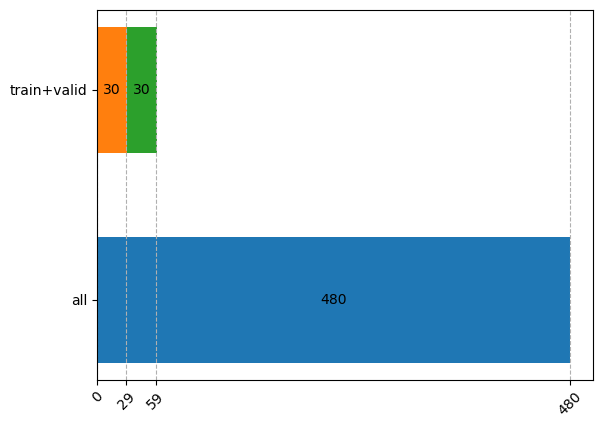

train_X.shape: (316580, 19), train_y.shape: (316580, 1)
valid_X.shape: (319354, 19), valid_y.shape: (319354, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.0773
      | mae = 5.0770
-------------------------------------------
best  | loss = 5.2439
      | mae = 5.2439
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.0753
      | mae = 5.0753
-------------------------------------------
best  | loss = 5.2389
      | mae = 5.2389
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.0667
      | mae = 5.0670
-------------------------------------------
best  | loss = 5.2349
      | mae = 5.2349
-----------------------------------------

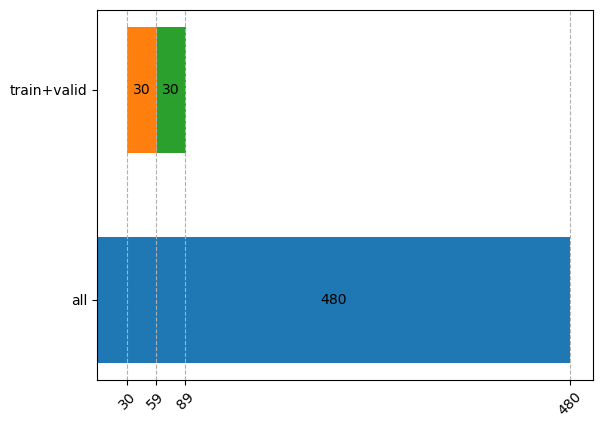

train_X.shape: (319354, 19), train_y.shape: (319354, 1)
valid_X.shape: (322960, 19), valid_y.shape: (322960, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.2550
      | mae = 5.2550
-------------------------------------------
best  | loss = 6.4520
      | mae = 6.4524
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.2450
      | mae = 5.2450
-------------------------------------------
best  | loss = 6.4551
      | mae = 6.4555
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.2147
      | mae = 5.2147
-------------------------------------------
best  | loss = 6.4195
      | mae = 6.4200
-----------------------------------------

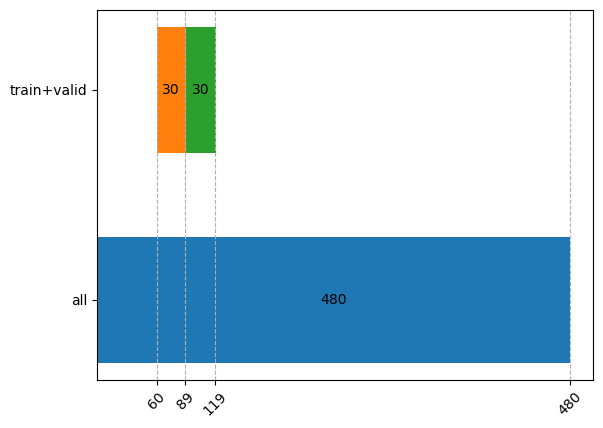

train_X.shape: (322960, 19), train_y.shape: (322960, 1)
valid_X.shape: (325050, 19), valid_y.shape: (325050, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4289
      | mae = 6.4286
-------------------------------------------
best  | loss = 6.9496
      | mae = 6.9481
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4128
      | mae = 6.4130
-------------------------------------------
best  | loss = 6.9446
      | mae = 6.9430
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4038
      | mae = 6.4032
-------------------------------------------
best  | loss = 6.9268
      | mae = 6.9252
-----------------------------------------

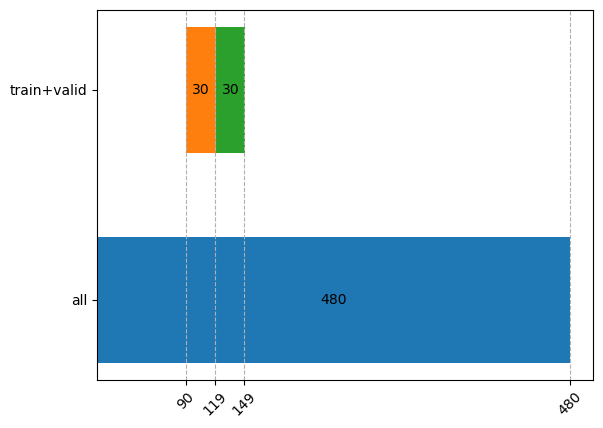

train_X.shape: (325050, 19), train_y.shape: (325050, 1)
valid_X.shape: (324995, 19), valid_y.shape: (324995, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.9609
      | mae = 6.9608
-------------------------------------------
best  | loss = 7.7864
      | mae = 7.7852
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.9326
      | mae = 6.9325
-------------------------------------------
best  | loss = 7.7524
      | mae = 7.7514
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.8959
      | mae = 6.8960
-------------------------------------------
best  | loss = 7.7236
      | mae = 7.7225
-----------------------------------------

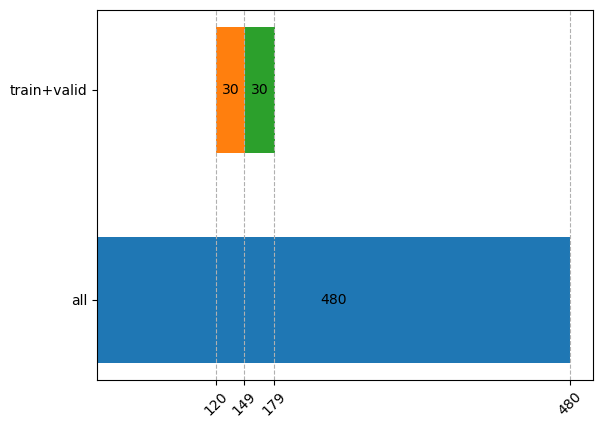

train_X.shape: (324995, 19), train_y.shape: (324995, 1)
valid_X.shape: (325050, 19), valid_y.shape: (325050, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 7.7342
      | mae = 7.7358
-------------------------------------------
best  | loss = 6.5929
      | mae = 6.5930
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 7.7115
      | mae = 7.7119
-------------------------------------------
best  | loss = 6.5826
      | mae = 6.5828
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 7.6962
      | mae = 7.6976
-------------------------------------------
best  | loss = 6.5709
      | mae = 6.5711
-----------------------------------------

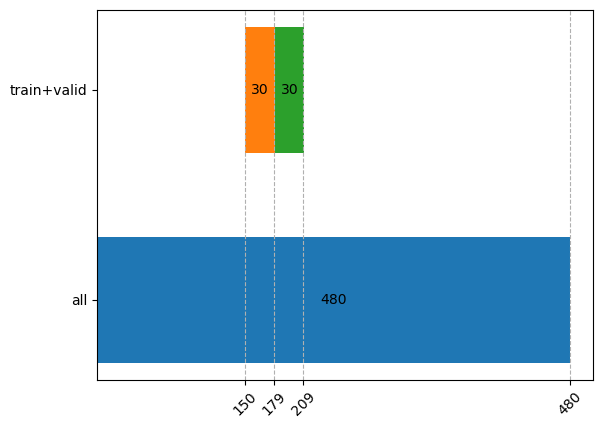

train_X.shape: (325050, 19), train_y.shape: (325050, 1)
valid_X.shape: (327690, 19), valid_y.shape: (327690, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.5812
      | mae = 6.5810
-------------------------------------------
best  | loss = 7.6707
      | mae = 7.6710
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.5744
      | mae = 6.5744
-------------------------------------------
best  | loss = 7.6594
      | mae = 7.6597
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.5588
      | mae = 6.5589
-------------------------------------------
best  | loss = 7.6451
      | mae = 7.6453
-----------------------------------------

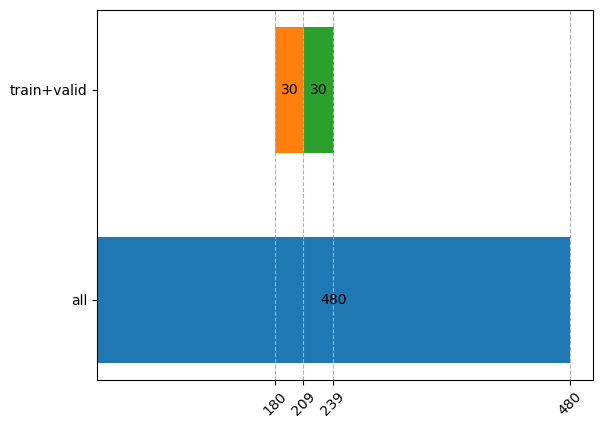

train_X.shape: (327690, 19), train_y.shape: (327690, 1)
valid_X.shape: (328350, 19), valid_y.shape: (328350, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 7.6823
      | mae = 7.6828
-------------------------------------------
best  | loss = 6.4946
      | mae = 6.4946
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 7.6392
      | mae = 7.6384
-------------------------------------------
best  | loss = 6.4573
      | mae = 6.4572
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 7.6160
      | mae = 7.6157
-------------------------------------------
best  | loss = 6.4497
      | mae = 6.4497
-----------------------------------------

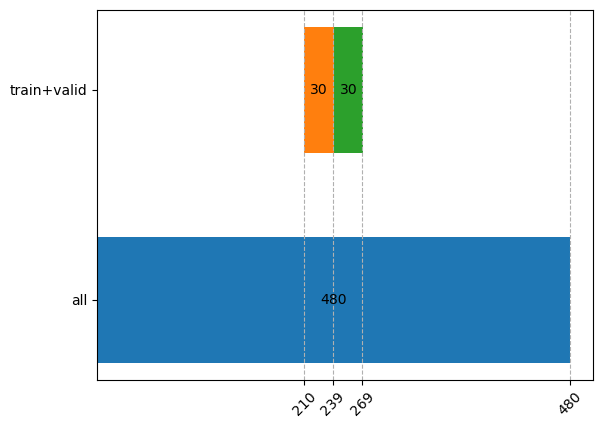

train_X.shape: (328350, 19), train_y.shape: (328350, 1)
valid_X.shape: (328350, 19), valid_y.shape: (328350, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4617
      | mae = 6.4613
-------------------------------------------
best  | loss = 5.8615
      | mae = 5.8614
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4411
      | mae = 6.4410
-------------------------------------------
best  | loss = 5.8534
      | mae = 5.8532
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4369
      | mae = 6.4372
-------------------------------------------
best  | loss = 5.8534
      | mae = 5.8532
-----------------------------------------

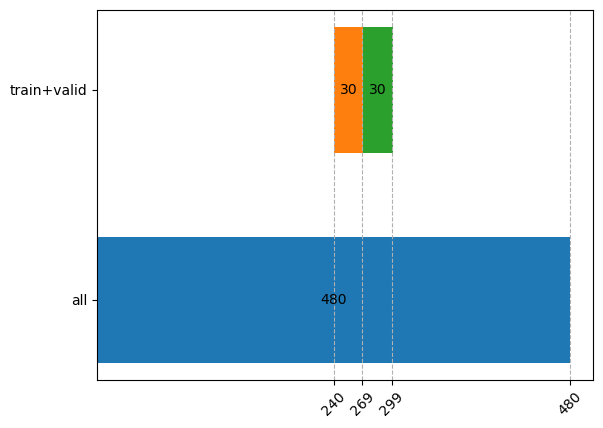

train_X.shape: (328350, 19), train_y.shape: (328350, 1)
valid_X.shape: (328625, 19), valid_y.shape: (328625, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.8589
      | mae = 5.8589
-------------------------------------------
best  | loss = 6.0965
      | mae = 6.0961
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.8708
      | mae = 5.8708
-------------------------------------------
best  | loss = 6.1040
      | mae = 6.1035
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.8431
      | mae = 5.8432
-------------------------------------------
best  | loss = 6.0815
      | mae = 6.0811
-----------------------------------------

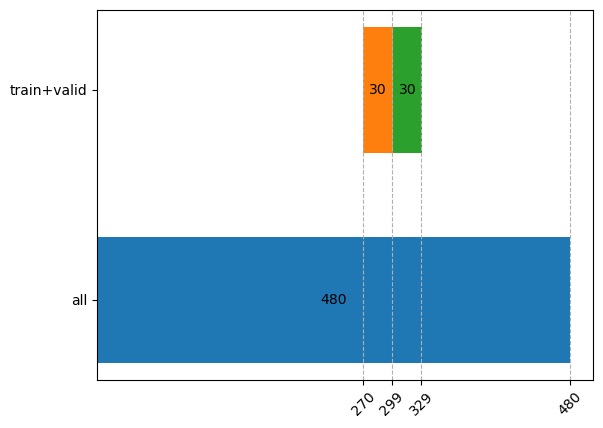

train_X.shape: (328625, 19), train_y.shape: (328625, 1)
valid_X.shape: (329944, 19), valid_y.shape: (329944, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.0932
      | mae = 6.0933
-------------------------------------------
best  | loss = 6.5979
      | mae = 6.5980
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.0728
      | mae = 6.0727
-------------------------------------------
best  | loss = 6.5789
      | mae = 6.5790
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.0686
      | mae = 6.0686
-------------------------------------------
best  | loss = 6.5764
      | mae = 6.5764
-----------------------------------------

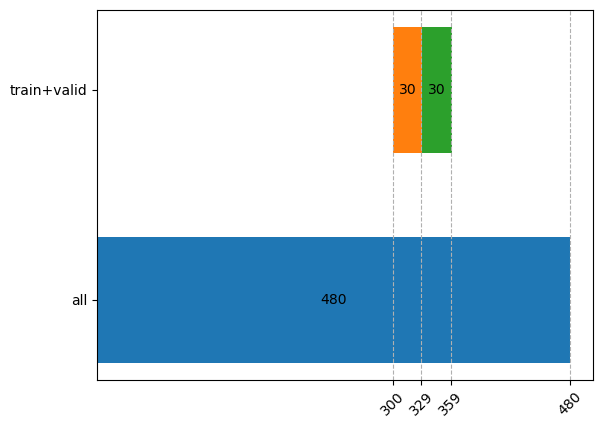

train_X.shape: (329944, 19), train_y.shape: (329944, 1)
valid_X.shape: (330000, 19), valid_y.shape: (330000, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.5820
      | mae = 6.5820
-------------------------------------------
best  | loss = 6.2519
      | mae = 6.2522
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.5691
      | mae = 6.5689
-------------------------------------------
best  | loss = 6.2408
      | mae = 6.2410
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.5610
      | mae = 6.5610
-------------------------------------------
best  | loss = 6.2431
      | mae = 6.2434
-----------------------------------------

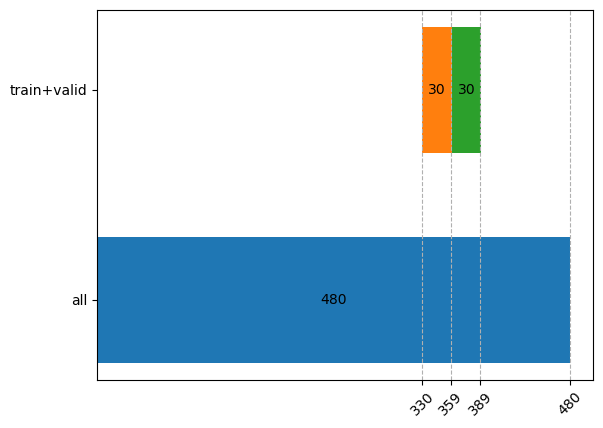

train_X.shape: (330000, 19), train_y.shape: (330000, 1)
valid_X.shape: (329945, 19), valid_y.shape: (329945, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.2465
      | mae = 6.2470
-------------------------------------------
best  | loss = 6.4844
      | mae = 6.4845
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.2208
      | mae = 6.2213
-------------------------------------------
best  | loss = 6.4699
      | mae = 6.4700
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.2187
      | mae = 6.2192
-------------------------------------------
best  | loss = 6.4703
      | mae = 6.4704
-----------------------------------------

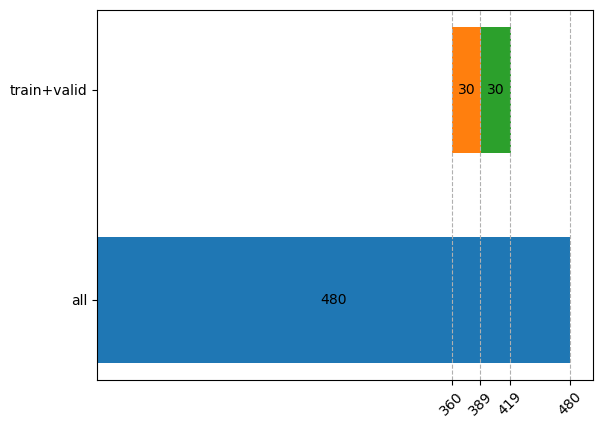

train_X.shape: (329945, 19), train_y.shape: (329945, 1)
valid_X.shape: (330000, 19), valid_y.shape: (330000, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4887
      | mae = 6.4887
-------------------------------------------
best  | loss = 6.4302
      | mae = 6.4305
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4698
      | mae = 6.4698
-------------------------------------------
best  | loss = 6.4096
      | mae = 6.4100
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4603
      | mae = 6.4604
-------------------------------------------
best  | loss = 6.4075
      | mae = 6.4078
-----------------------------------------

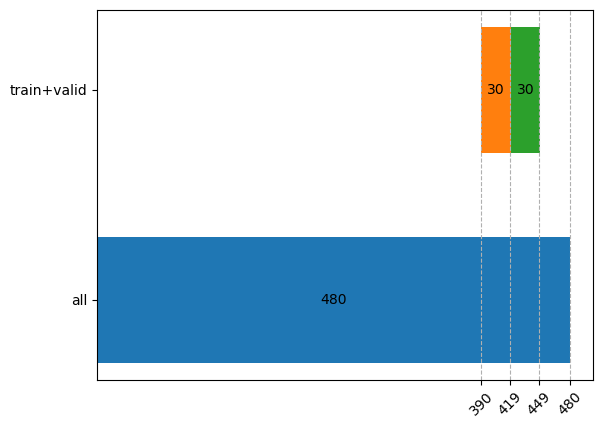

train_X.shape: (330000, 19), train_y.shape: (330000, 1)
valid_X.shape: (329999, 19), valid_y.shape: (329999, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4125
      | mae = 6.4118
-------------------------------------------
best  | loss = 5.6593
      | mae = 5.6599
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.3920
      | mae = 6.3923
-------------------------------------------
best  | loss = 5.6543
      | mae = 5.6550
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.3806
      | mae = 6.3800
-------------------------------------------
best  | loss = 5.6448
      | mae = 5.6454
-----------------------------------------

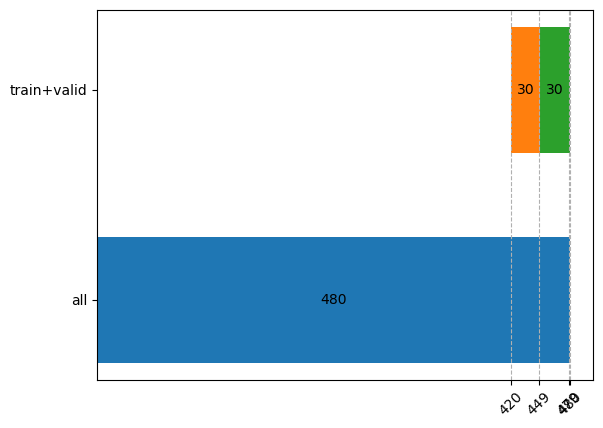

train_X.shape: (329999, 19), train_y.shape: (329999, 1)
valid_X.shape: (330000, 19), valid_y.shape: (330000, 1)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.6602
      | mae = 5.6606
-------------------------------------------
best  | loss = 5.9308
      | mae = 5.9312
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.6415
      | mae = 5.6412
-------------------------------------------
best  | loss = 5.9113
      | mae = 5.9116
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.6339
      | mae = 5.6331
-------------------------------------------
best  | loss = 5.9121
      | mae = 5.9124
-----------------------------------------

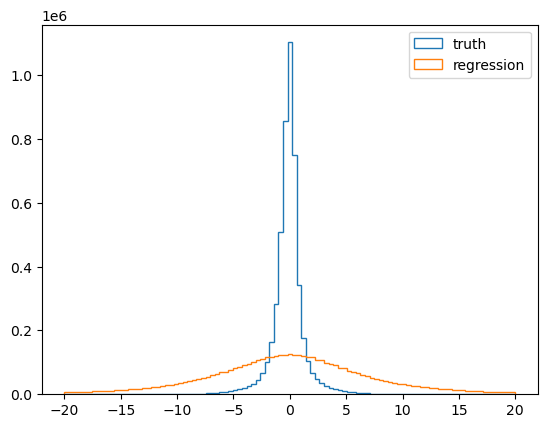

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kfold_params = {
    'n_splits': 15,
    'max_train_size': 30,
    'test_size': 30,
    'gap': 0,
}

history = train_using_cv(
    kfold_params=kfold_params,
    dataset=train_df,
    outputs_dir=outputs_dir_path, 
)

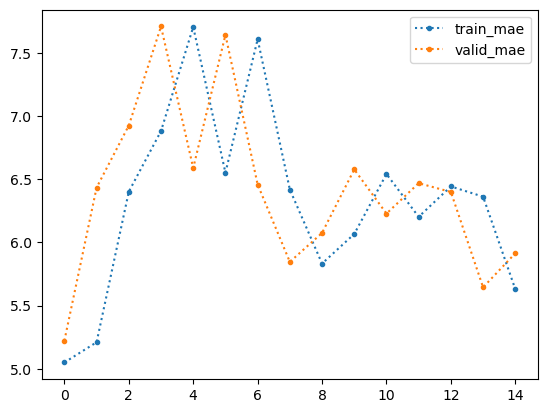

In [8]:
history.plot(marker='.', linestyle=':')
plt.show()